<a href="https://colab.research.google.com/github/madhayhansen/ds4a-ws19-11/blob/master/DS4A_Project%20JS%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import pandas as pd
import folium  #needed for interactive map
from folium.plugins import HeatMap
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
  

# Google Drive authorization

In [0]:
# Google Drive imports and authorization

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Loading CSV files into pandas

In [0]:
# creating csv files within colab environment

file_list = drive.ListFile({'q': "'1sK4TQCIdr6pyrmCKrfDEv8Z4GcM-1jD-' in parents and trashed=false"}).GetList()
for file1 in [f for f in file_list if f['title'].endswith('.csv')]:
    print('title: %s, id: %s' % (file1['title'], file1['id']))
    temp_file = drive.CreateFile({'id': file1['id']})
    temp_file.GetContentFile(file1['title'])

title: geographic.csv, id: 1Zaf48jT6RVJcteVKBkGLwRHRocnLiZZA
title: mta_trips.csv, id: 1h6cnlLbyS9oDkQxd0QITuDSfz2N2vkie
title: green_trips.csv, id: 1wB5xKwU3P7-ZdeXud6IXU54HUGInp7e_
title: yellow_trips.csv, id: 17PQgtknZXYTr52ifT4aST-Ak-fJ-cwvB
title: uber_trips_2014.csv, id: 1o9mGz9bSdFhcblfsnAHs3zBkI_2jyYBh
title: uber_trips_2015.csv, id: 1yX88JyAU3v8fy4yXXS4JTuVla2vWD1yW


In [0]:
mta_trips = pd.read_csv('mta_trips.csv')
uber_15 = pd.read_csv("uber_trips_2015.csv")
zones = pd.read_csv("zones.csv")
geographic = pd.read_csv("geographic.csv")
uber_14 = pd.read_csv("uber_trips_2014.csv")
weather = pd.read_csv("weather.csv")
demographics = pd.read_csv("demographics.csv")

# Cleaning geographic dataframe

In [0]:
numrows = geographic.shape[0]
numobvs = int(numrows / 2)
s = ['long', 'lat']
llcolumn = s*numobvs
len(llcolumn)

new_geographic = geographic.assign(LL= llcolumn)
geo_melt = new_geographic.melt(id_vars=['LL'])

numobvs2 = int(geographic.shape[0]*geographic.shape[1] / 2) 

obvslist = [item for item in range(numobvs2) for i in [0,1]]

new_geo_melt = geo_melt.assign(vertexNumber= obvslist)
new_geo_melt.columns = ["LL", "NTA", "value", "vertexNumber"]

geographic_clean = new_geo_melt.pivot_table('value', ['vertexNumber', "NTA"], 'LL') 
geographic_clean.head()


In [0]:
# Madison working on identifying NTA given (lat, long)

nta_min_max = geographic_clean.groupby("NTA").agg({"lat": ["min", "max"], "long":["min","max"]})
                          
nta_min_max.columns = ["latmin", "latmax", "longmin", "longmax"]
                                                   
# nta_min_max

mylat = 40.689136
mylong = -100



# nta_min_max.loc[(nta_min_max['latmin'] < mylat) & (nta_min_max['latmax'] > mylat) & (nta_min_max['longmin'] < mylong) & (nta_min_max['longmax'] > mylong)]

def getNTAfromLatLong(nta_min_max, mylat, mylong):
  result = nta_min_max.loc[(nta_min_max['latmin'] < mylat) & (nta_min_max['latmax'] > mylat) & (nta_min_max['longmin'] < mylong) & (nta_min_max['longmax'] > mylong)].index.values
  if result.shape[0]<1:
    return np.nan
  else:
    return result[0]
  
getNTAfromLatLong(nta_min_max, 40.689136, -74.001795)


getNTAfromLatLong(nta_min_max, mylat, mylong)




# Adding NTA to Uber 2015

In [0]:
uber_2015 = uber_15.merge(zones, how = "left", left_on = "pickup_location_id", right_on = "location_id")
uber_2015.head()

In [0]:
uber_2015new = uber_2015.merge(demographics, how = "left", left_on = "nta_code", right_on = "nta_code")

In [0]:
nta1 = uber_2015new.groupby('nta_name')["pickup_datetime"].count().rename("trips").reset_index()

In [0]:
demo = demographics.merge(nta1, how = "left", left_on = "nta_name", right_on = "nta_name")

In [0]:
demo

In [0]:
#mask = (demo['median_income'] > 100000)
#high_income = demo[mask]

In [0]:
#uber_14.head()

In [0]:
#uber_14['NTA'] = uber_14.apply(lambda x: getNTAfromLatLong(nta_min_max, x['pickup_latitude'], x['pickup_longitude']), axis=1)

#uber_14.isna().any()

In [0]:
#uber_14.columns

# Misc 

In [0]:
# testing try again to see if it refreshes

In [0]:
geographic.dropna()
polygons = geographic.to_dict('list')

import numbers

for k, v in polygons.items():
    polygons[k] = [i for i in v if str(i) != 'nan']

for key in polygons:
    it = iter(polygons[key])
    tuples = list(zip(it, it))
    polygons.update({key: tuples})
    
print(polygons['QN29'])

In [0]:
# Testing Even-Odd Rule for polygon problem

def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    """
    num = len(poly)
    i = 0
    j = num - 1
    c = False
    for i in range(num):
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                  (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c

In [0]:
sample = uber_14.head(10)

nta_code = []
for idx,row in sample.iterrows():
    x = row["pickup_longitude"]
    y = row["pickup_latitude"]
    #print(idx,x,y)
    for poly in polygons:
        nta = 0
        lat_long_check = is_point_in_path(x, y, polygons[poly])
        #print(lat_long_check)
        if lat_long_check != False: #WHY IS EVERYTHING FALSE?
            nta = poly
    nta_code.append(nta)

sample["nta_code"] = nta_code
sample

In [0]:
uber_2015.tail()

In [0]:
numrows = geographic.shape[1]
numobvs = numrows / 2
s = pd.Series(['long', 'lat'])
llcolumn = s.repeat(numobvs)
new_geographic = geographic.assign(address = ['Delhi', 'Bangalore', 'Chennai', 'Patna']) 

# Adding NTA codes to MTA data

In [0]:
mta_trips.head()

In [0]:
mta_station = mta_trips.groupby(by = "station").first()

#len(mta_trips["station"].unique()) #Should have 345 unique lat, long pairs 

mta_station.head()

In [0]:
getNTAfromLatLong(nta_min_max, 40.800605, -73.958158)

In [0]:
mta_station.dtypes

In [0]:
mta_station['NTA'] = mta_station.apply(lambda x: getNTAfromLatLong(nta_min_max, x['latitude'], x['longitude']), axis=1)

mta_station.isna().any()

In [0]:
np.sum(mta_station["NTA"].isna().values)

In [0]:
mta_withNTA = mta_trips.merge(mta_station["NTA"], how = "left", left_on = "station", right_on = mta_station.index)

In [0]:
mta_withNTA.tail()

# Uber and MTA Demographics

In [236]:
demo.head()

,nta_name,borough,nta_code,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,30-34_years,35-39_years,40-44_years,45-49_years,50-54_years,55-59_years,60-64_years,over_65_years,median_age,people_per_acre,households,"less_than_10,000",10000_to_14999,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income,trips
0,Allerton-Pelham Gardens,Bronx,BX31,28903,1679,1706,1763,2039,1964,1703,1798,1654,1937,2203,2027,1785,1619,5026,40,39.8,9587,836,348,797,773,1160,1764,1155,1562,765,427,61638,78489,3684.0
1,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,SI01,27770,1397,1698,1817,1880,1720,1594,1487,1814,2073,2274,2246,1961,1869,3940,41,8.4,9885,467,253,571,405,1008,1523,1346,2075,1086,1151,88288,109187,39.0
2,Arden Heights,Staten Island,SI48,25238,1507,1540,1596,1752,1614,1561,1726,1828,1914,1892,1910,1945,1763,2690,39,21.8,8960,304,256,337,516,707,1421,1611,2021,1047,740,89570,101627,26.0
3,Astoria,Queens,QN70,78793,3480,3037,3060,3392,6630,11586,9252,6843,5633,4944,4599,4018,3373,8946,34,87.3,34310,2772,1782,3673,2816,4725,6463,4557,4698,1627,1197,54882,70094,91239.0
4,Auburndale,Queens,QN48,19996,917,966,1063,1168,1214,1307,1296,1336,1451,1557,1659,1560,1326,3176,43,25.5,7122,270,349,445,632,690,1417,1060,1237,589,433,70772,84402,3040.0


In [272]:
demo.head()

,nta_name,borough,nta_code,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,30-34_years,35-39_years,40-44_years,45-49_years,50-54_years,55-59_years,60-64_years,over_65_years,median_age,people_per_acre,households,"less_than_10,000",10000_to_14999,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income,trips
0,Allerton-Pelham Gardens,Bronx,BX31,28903,1679,1706,1763,2039,1964,1703,1798,1654,1937,2203,2027,1785,1619,5026,40,39.8,9587,836,348,797,773,1160,1764,1155,1562,765,427,61638,78489,3684.0
1,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,SI01,27770,1397,1698,1817,1880,1720,1594,1487,1814,2073,2274,2246,1961,1869,3940,41,8.4,9885,467,253,571,405,1008,1523,1346,2075,1086,1151,88288,109187,39.0
2,Arden Heights,Staten Island,SI48,25238,1507,1540,1596,1752,1614,1561,1726,1828,1914,1892,1910,1945,1763,2690,39,21.8,8960,304,256,337,516,707,1421,1611,2021,1047,740,89570,101627,26.0
3,Astoria,Queens,QN70,78793,3480,3037,3060,3392,6630,11586,9252,6843,5633,4944,4599,4018,3373,8946,34,87.3,34310,2772,1782,3673,2816,4725,6463,4557,4698,1627,1197,54882,70094,91239.0
4,Auburndale,Queens,QN48,19996,917,966,1063,1168,1214,1307,1296,1336,1451,1557,1659,1560,1326,3176,43,25.5,7122,270,349,445,632,690,1417,1060,1237,589,433,70772,84402,3040.0


In [280]:
# demo_sorted = demo.sort_values(by=['people_per_acre'], ascending=False)
# demo_sorted
demo_sorted["tripsperperson"] = demo_sorted["trips"]/demo_sorted["population"]

# xx = demo_sorted.head(5).plot.bar(x='nta_name', y='trips', rot=90)
# sns.barplot(x="nta_name", y="trips", data=demo_sorted.head(10))

# todo: trips per person in the graph instead DONE!

# todo: linear regression correlation income and trips per person

# demo_sorted.head()


import statsmodels.formula.api as sm


result = sm.ols(formula="trips ~ population + median_age + (median_income)", data=demo_sorted).fit()
result.params
print(result.summary())
result.params

                            OLS Regression Results                            
Dep. Variable:                  trips   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     34.83
Date:                Thu, 24 Oct 2019   Prob (F-statistic):           8.04e-18
Time:                        02:06:25   Log-Likelihood:                -2491.3
No. Observations:                 185   AIC:                             4991.
Df Residuals:                     181   BIC:                             5004.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.657e+05   1.07e+05      1.553

Intercept        165656.941213
population            1.788141
median_age       -14068.659206
median_income         5.903865
dtype: float64

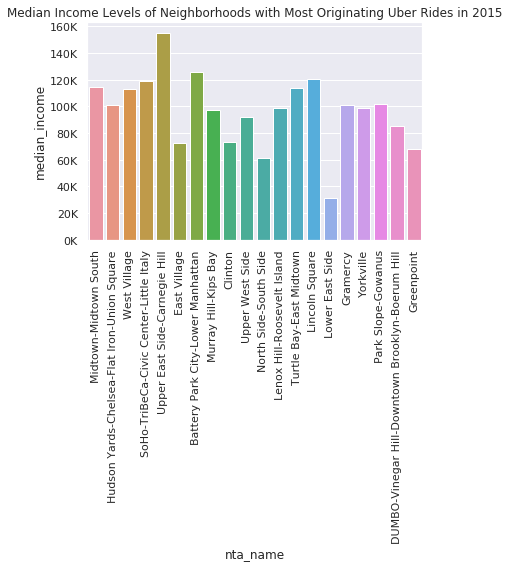

In [267]:

demo_sorted = demo.sort_values(by=['trips'], ascending=False)
g = sns.barplot(x="nta_name", y="median_income", data=demo_sorted.head(20))
plt.xticks(rotation=90)
plt.title("Median Income Levels of Neighborhoods with Most Originating Uber Rides in 2015")
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)
plt.savefig('uberdemo1.png')

# demo_sorted.head(10)

# demo_sorted = demo.sort_values(by=['trips'], ascending=True)
# g = sns.barplot(x="nta_name", y="median_income", data=demo_sorted.head(10))
# plt.xticks(rotation=90)
# demo_sorted.head(10)

[Text(0, 0, '0K'),
 Text(0, 0, '20K'),
 Text(0, 0, '40K'),
 Text(0, 0, '60K'),
 Text(0, 0, '80K'),
 Text(0, 0, '100K')]

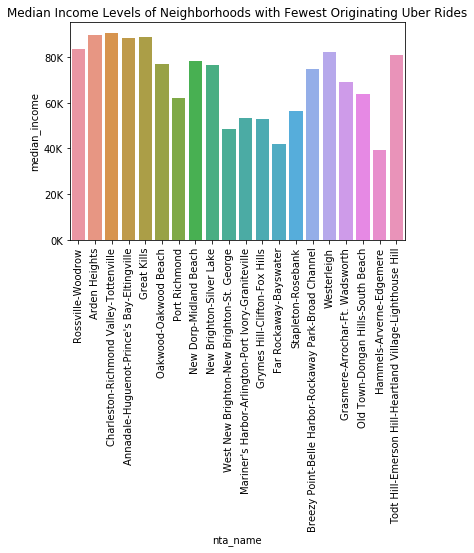

In [118]:
demo_sorted = demo.sort_values(by=['trips'], ascending=True)
g = sns.barplot(x="nta_name", y="median_income", data=demo_sorted.head(20))
plt.xticks(rotation=90)
plt.title("Median Income Levels of Neighborhoods with Fewest Originating Uber Rides in 2015")
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)

[Text(0, 0, '0K'),
 Text(0, 0, '20K'),
 Text(0, 0, '40K'),
 Text(0, 0, '60K'),
 Text(0, 0, '80K'),
 Text(0, 0, '100K'),
 Text(0, 0, '120K'),
 Text(0, 0, '140K')]

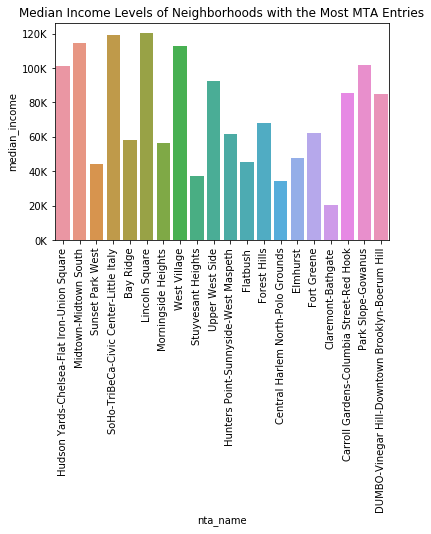

In [120]:
demo_sorted = mta15demo.sort_values(by=['new_entries'], ascending=False)
g = sns.barplot(x="nta_name", y="median_income", data=demo_sorted.head(20))
plt.xticks(rotation=90)
plt.title("Median Income Levels of Neighborhoods with the Most MTA Entries  in 2015")
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)

[Text(0, 0, '0K'),
 Text(0, 0, '20K'),
 Text(0, 0, '40K'),
 Text(0, 0, '60K'),
 Text(0, 0, '80K'),
 Text(0, 0, '100K'),
 Text(0, 0, '120K')]

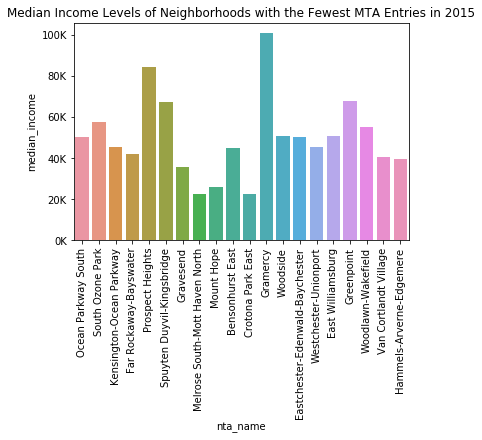

In [179]:
demo_sorted = mta15demo.sort_values(by=['new_entries'], ascending=True)
g = sns.barplot(x="nta_name", y="median_income", data=demo_sorted.head(20))
plt.xticks(rotation=90)
plt.title("Median Income Levels of Neighborhoods with the Fewest MTA Entries in 2015")
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)

In [135]:
demo.columns
mta15demo.columns

Index(['new_entries', 'new_exits', 'latitude', 'longitude', 'nta_name',
       'borough', 'nta_code', 'population', 'under_5_years', '5-9_years',
       '10-14_years', '15-19_years', '20-24_years', '25-29_years',
       '30-34_years', '35-39_years', '40-44_years', '45-49_years',
       '50-54_years', '55-59_years', '60-64_years', 'over_65_years',
       'median_age', 'people_per_acre', 'households', 'less_than_10,000',
       '10000_to_14999', '15000_to_24999', '25000_to_34999', '35000_to_49999',
       '50000_to_74999', '75000_to_99999', '100000_to_149999',
       '150000_to_199999', '200000_or_more', 'median_income', 'mean_income'],
      dtype='object')

In [0]:
# combine demo info with Uber 15 initiated trips and MTA new entries
cols_to_use = mta15demo.columns.difference(demo.columns)
mergedemo = pd.merge(demo, mta15demo[cols_to_use], left_index=True, right_index=True, how='outer')

In [222]:
# mergedemo.columns
mergedemo["mtauberratio"] = mergedemo["new_entries"]/mergedemo["trips"]

# uber to mta convert to % 
mergedemo["ubermtapct"] = mergedemo["trips"]/mergedemo["new_entries"]*100
mergedemo.head()

,nta_name,borough,nta_code,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,30-34_years,35-39_years,40-44_years,45-49_years,50-54_years,55-59_years,60-64_years,over_65_years,median_age,people_per_acre,households,"less_than_10,000",10000_to_14999,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income,trips,latitude,longitude,new_entries,new_exits,ubermtaratio,mtauberratio,ubermtapct
0,Allerton-Pelham Gardens,Bronx,BX31,28903,1679,1706,1763,2039,1964,1703,1798,1654,1937,2203,2027,1785,1619,5026,40,39.8,9587,836,348,797,773,1160,1764,1155,1562,765,427,61638,78489,3684.0,4.254223e+05,-7.734337e+05,2276053.0,2062879.0,0.001619,617.821118,0.161859
1,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,SI01,27770,1397,1698,1817,1880,1720,1594,1487,1814,2073,2274,2246,1961,1869,3940,41,8.4,9885,467,253,571,405,1008,1523,1346,2075,1086,1151,88288,109187,39.0,1.095109e+06,-1.995088e+06,4762263.0,3110942.0,0.000008,122109.307692,0.000819
2,Arden Heights,Staten Island,SI48,25238,1507,1540,1596,1752,1614,1561,1726,1828,1914,1892,1910,1945,1763,2690,39,21.8,8960,304,256,337,516,707,1421,1611,2021,1047,740,89570,101627,26.0,7.949494e+05,-1.449014e+06,2390778.0,1547018.0,0.000011,91953.000000,0.001088
3,Astoria,Queens,QN70,78793,3480,3037,3060,3392,6630,11586,9252,6843,5633,4944,4599,4018,3373,8946,34,87.3,34310,2772,1782,3673,2816,4725,6463,4557,4698,1627,1197,54882,70094,91239.0,1.027465e+06,-1.873228e+06,2911934.0,2433921.0,0.031333,31.915453,3.133278
4,Auburndale,Queens,QN48,19996,917,966,1063,1168,1214,1307,1296,1336,1451,1557,1659,1560,1326,3176,43,25.5,7122,270,349,445,632,690,1417,1060,1237,589,433,70772,84402,3040.0,9.327405e+05,-1.698735e+06,4315339.0,3680169.0,0.000704,1419.519408,0.070446


In [181]:
demo_sorted = mergedemo.sort_values(by=['ubermtapct'], ascending=False)
demo_sorted.head()

,nta_name,borough,nta_code,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,30-34_years,35-39_years,40-44_years,45-49_years,50-54_years,55-59_years,60-64_years,over_65_years,median_age,people_per_acre,households,"less_than_10,000",10000_to_14999,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income,trips,latitude,longitude,new_entries,new_exits,ubermtaratio,mtauberratio
83,Hudson Yards-Chelsea-Flat Iron-Union Square,Manhattan,MN13,70150,2601,1646,1339,1891,6111,9675,8828,6684,6044,5331,4664,4070,3645,7621,37,82.4,41343,2439,1421,2694,2156,3422,4460,3866,6217,3957,10711,101369,182129,1380265.0,425869.314395,-7.720104e+05,3349793.0,2738105.0,0.412045,2.426920
95,Lincoln Square,Manhattan,MN14,61489,3656,2036,1547,2104,3274,6009,6997,5709,4701,4003,3876,3707,3720,10150,40,165.7,31811,1998,824,1839,1207,1820,3088,2989,4721,3851,9474,120337,188144,311722.0,302229.922554,-5.479530e+05,1873219.0,1374644.0,0.166410,6.009261
54,East Village,Manhattan,MN22,44136,862,617,598,3259,7381,7720,5090,3376,2720,2463,2221,2145,1670,4014,31,176.5,22326,2089,888,2072,1524,1702,3160,3057,3201,2155,2478,72665,100130,496910.0,942760.268790,-1.703848e+06,3914510.0,1800593.0,0.126941,7.877704
72,Gramercy,Manhattan,MN21,27988,708,445,380,1794,3626,4811,3339,2207,1640,1451,1445,1375,1498,3269,33,163.0,14734,921,348,715,587,894,2044,1810,2325,2049,3041,100900,148602,251499.0,249216.777180,-4.517254e+05,2011329.0,1535330.0,0.125041,7.997364
43,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,Brooklyn,BK38,34495,2255,1532,1550,1669,2264,3986,4424,3565,2781,2333,1896,1676,1483,3081,35,53.6,16263,1538,802,1351,805,1317,1674,1620,2587,1569,3000,84945,123292,176416.0,301965.714818,-5.461310e+05,1654698.0,1169416.0,0.106615,9.379523


[Text(0, 0, '0%'),
 Text(0, 0, '5%'),
 Text(0, 0, '10%'),
 Text(0, 0, '15%'),
 Text(0, 0, '20%'),
 Text(0, 0, '25%'),
 Text(0, 0, '30%'),
 Text(0, 0, '35%'),
 Text(0, 0, '40%'),
 Text(0, 0, '45%')]

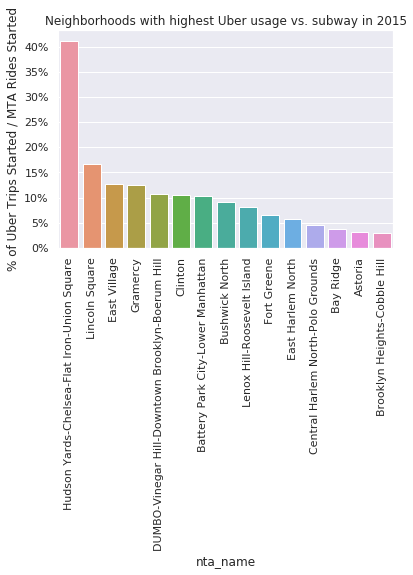

In [227]:
palette = sns.color_palette("muted")
sns.set()
demo_sorted = mergedemo.sort_values(by=['ubermtapct'], ascending=False)

g = sns.barplot(x="nta_name", y="ubermtapct", data=demo_sorted.head(15))
plt.xticks(rotation=90)
plt.title("Neighborhoods with highest Uber usage vs. subway in 2015")

ylabels = ['{:,.0f}'.format(y) + '%' for y in g.get_yticks()]
plt.ylabel("% of Uber Trips Started / MTA Rides Started")
g.set_yticklabels(ylabels)

In [234]:


demo_sorted.head()

,nta_name,borough,nta_code,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,30-34_years,35-39_years,40-44_years,45-49_years,50-54_years,55-59_years,60-64_years,over_65_years,median_age,people_per_acre,households,"less_than_10,000",10000_to_14999,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income,trips,latitude,longitude,new_entries,new_exits,ubermtaratio,mtauberratio,ubermtapct
1,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,SI01,27770,1397,1698,1817,1880,1720,1594,1487,1814,2073,2274,2246,1961,1869,3940,41,8.4,9885,467,253,571,405,1008,1523,1346,2075,1086,1151,88288,109187,39.0,1.095109e+06,-1.995088e+06,4762263.0,3110942.0,0.000008,122109.307692,0.000819
30,Charleston-Richmond Valley-Tottenville,Staten Island,SI11,23313,1372,1729,1674,1593,1442,1385,1516,1855,2175,2119,1794,1362,1091,2206,38,6.8,7853,218,368,533,371,610,1097,1155,1708,835,958,90788,108550,37.0,8.130733e+05,-1.476541e+06,4141261.0,2299573.0,0.000009,111925.972973,0.000893
2,Arden Heights,Staten Island,SI48,25238,1507,1540,1596,1752,1614,1561,1726,1828,1914,1892,1910,1945,1763,2690,39,21.8,8960,304,256,337,516,707,1421,1611,2021,1047,740,89570,101627,26.0,7.949494e+05,-1.449014e+06,2390778.0,1547018.0,0.000011,91953.000000,0.001088
75,Great Kills,Staten Island,SI54,40720,2227,2389,2582,2657,2408,2360,2389,2697,2972,3319,3342,2872,2633,5873,41,19.6,15618,458,431,1107,904,1266,2357,2318,3630,1997,1150,88868,101538,145.0,1.219159e+06,-2.211998e+06,8609323.0,5920584.0,0.000017,59374.641379,0.001684
60,Far Rockaway-Bayswater,Queens,QN15,50058,4557,3846,3661,3939,3659,3674,3324,3009,2945,3003,2967,2792,2214,6468,33,40.0,16341,2730,1268,2197,1239,1696,2505,1831,1607,640,628,41916,59418,548.0,2.424368e+06,-4.391046e+06,12678676.0,8405803.0,0.000043,23136.270073,0.004322


[Text(0, 0, '0%'),
 Text(0, 0, '0%'),
 Text(0, 0, '0%'),
 Text(0, 0, '0%'),
 Text(0, 0, '0%'),
 Text(0, 0, '0%'),
 Text(0, 0, '0%'),
 Text(0, 0, '0%')]

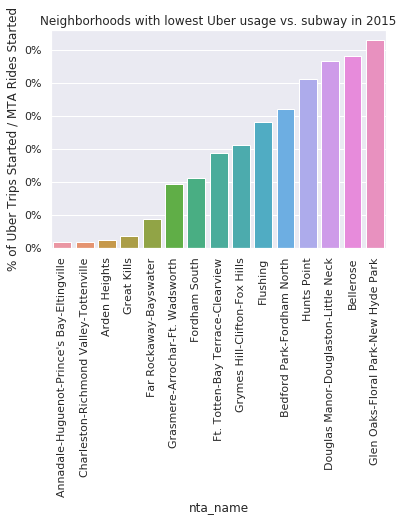

In [235]:
demo_sorted = mergedemo.sort_values(by=['ubermtapct'], ascending=True)

palette = sns.color_palette("muted")
sns.set()
g = sns.barplot(x="nta_name", y="ubermtapct", data=demo_sorted.head(15))

plt.xticks(rotation=90)
plt.title("Neighborhoods with lowest Uber usage vs. subway in 2015")

ylabels = ['{:,.0f}'.format(y) + '%' for y in g.get_yticks()]
plt.ylabel("% of Uber Trips Started / MTA Rides Started")
g.set_yticklabels(ylabels)

In [254]:
mergedemo.head(20)

,nta_name,borough,nta_code,population,under_5_years,5-9_years,10-14_years,15-19_years,20-24_years,25-29_years,30-34_years,35-39_years,40-44_years,45-49_years,50-54_years,55-59_years,60-64_years,over_65_years,median_age,people_per_acre,households,"less_than_10,000",10000_to_14999,15000_to_24999,25000_to_34999,35000_to_49999,50000_to_74999,75000_to_99999,100000_to_149999,150000_to_199999,200000_or_more,median_income,mean_income,trips,latitude,longitude,new_entries,new_exits,ubermtaratio,mtauberratio,ubermtapct
0,Allerton-Pelham Gardens,Bronx,BX31,28903,1679,1706,1763,2039,1964,1703,1798,1654,1937,2203,2027,1785,1619,5026,40,39.8,9587,836,348,797,773,1160,1764,1155,1562,765,427,61638,78489,3684.0,4.254223e+05,-7.734337e+05,2276053.0,2062879.0,0.001619,617.821118,0.161859
1,Annadale-Huguenot-Prince's Bay-Eltingville,Staten Island,SI01,27770,1397,1698,1817,1880,1720,1594,1487,1814,2073,2274,2246,1961,1869,3940,41,8.4,9885,467,253,571,405,1008,1523,1346,2075,1086,1151,88288,109187,39.0,1.095109e+06,-1.995088e+06,4762263.0,3110942.0,0.000008,122109.307692,0.000819
2,Arden Heights,Staten Island,SI48,25238,1507,1540,1596,1752,1614,1561,1726,1828,1914,1892,1910,1945,1763,2690,39,21.8,8960,304,256,337,516,707,1421,1611,2021,1047,740,89570,101627,26.0,7.949494e+05,-1.449014e+06,2390778.0,1547018.0,0.000011,91953.000000,0.001088
3,Astoria,Queens,QN70,78793,3480,3037,3060,3392,6630,11586,9252,6843,5633,4944,4599,4018,3373,8946,34,87.3,34310,2772,1782,3673,2816,4725,6463,4557,4698,1627,1197,54882,70094,91239.0,1.027465e+06,-1.873228e+06,2911934.0,2433921.0,0.031333,31.915453,3.133278
4,Auburndale,Queens,QN48,19996,917,966,1063,1168,1214,1307,1296,1336,1451,1557,1659,1560,1326,3176,43,25.5,7122,270,349,445,632,690,1417,1060,1237,589,433,70772,84402,3040.0,9.327405e+05,-1.698735e+06,4315339.0,3680169.0,0.000704,1419.519408,0.070446
5,Baisley Park,Queens,QN76,34603,2198,2389,2569,2923,2699,2430,2264,2191,2414,2763,2585,2013,1469,3696,35,35.7,10730,637,385,820,941,1575,2186,1532,1718,629,307,59357,72664,6812.0,2.559151e+05,-4.664376e+05,876578.0,414795.0,0.007771,128.681445,0.777113
6,Bath Beach,Brooklyn,BK27,29931,1766,1668,1672,1581,1922,2234,2308,2241,2006,2080,2097,1930,1653,4773,39,62.3,11125,897,768,1091,932,1407,2016,1176,1606,711,521,55193,76037,3559.0,1.338942e+06,-2.439873e+06,7611272.0,3936960.0,0.000468,2138.598483,0.046760
7,Battery Park City-Lower Manhattan,Manhattan,MN25,39699,2272,1055,691,1453,5203,7559,5978,4206,2823,1945,1589,1398,1182,2345,31,82.7,21216,1197,420,800,609,960,1909,2416,3878,2377,6650,125434,185275,473634.0,1.096109e+06,-1.996964e+06,4595612.0,3393011.0,0.103062,9.702876,10.306223
8,Bay Ridge,Brooklyn,BK31,78607,4571,3998,3772,3802,4700,7214,6738,6207,5718,5618,5541,5090,4340,11298,39,50.5,34991,2654,1864,3575,3067,4056,5848,4154,4869,2498,2406,57980,82209,35927.0,3.393199e+05,-6.180507e+05,958775.0,590805.0,0.037472,26.686754,3.747177
9,Bayside-Bayside Hills,Queens,QN46,43808,2106,2199,2353,2694,2504,2832,2935,3014,3158,3569,3531,3197,2698,7018,42,23.6,16008,578,494,1284,1073,1680,2506,2360,3047,1710,1276,79120,94806,8880.0,7.785877e+05,-1.418551e+06,6199663.0,5034582.0,0.001432,698.160248,0.143234


In [263]:
result = sm.ols(formula='ubermtapct ~ people_per_acre + median_age + np.log(median_income)', data = mergedemo).fit()
result.params
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             ubermtapct   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     17.06
Date:                Thu, 24 Oct 2019   Prob (F-statistic):           6.85e-09
Time:                        02:00:00   Log-Likelihood:                -272.48
No. Observations:                  96   AIC:                             553.0
Df Residuals:                      92   BIC:                             563.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -72.28

In [0]:
demo_sorted = demo.sort_values(by=['median_income'], ascending=False)
demo_sorted
demo_sorted["tripsperperson"] = demo_sorted["trips"]/demo_sorted["population"]

xx = demo_sorted.head(5).plot.bar(x='nta_name', y='tripsperperson', rot=90)
sns.barplot(x="nta_name", y="tripsperperson", data=demo_sorted.head(10))

# todo: trips per person in the graph instead DONE!

# todo: linear regression correlation income and trips per person

# demo_sorted.head()


import statsmodels.formula.api as sm

result = sm.ols(formula="tripsperperson ~ median_income", data=demo_sorted).fit()
result.params
print(result.summary())

In [0]:
demo_sorted = demo.sort_values(by=['median_age'], ascending=True)
demo_sorted
demo_sorted["tripsperperson"] = demo_sorted["trips"]/demo_sorted["population"]

xx = demo_sorted.head(5).plot.bar(x='nta_name', y='tripsperperson', rot=90)
sns.barplot(x="nta_name", y="tripsperperson", data=demo_sorted.head(10))

# todo: trips per person in the graph instead DONE!

# todo: linear regression correlation income and trips per person

# demo_sorted.head()


import statsmodels.formula.api as sm

result = sm.ols(formula="tripsperperson ~ median_age + median_income", data=demo_sorted).fit()
result.params
print(result.summary())


result = sm.ols(formula="trips ~ median_age + median_income", data=demo_sorted).fit()
result.params
print(result.summary())
result.params


In [0]:
mta15demo.columns

# MTA data

In [0]:
#mta_withNTA["year"] = 
mta_withNTA["datetime"].dtype

In [0]:
#NTA analysis for MTA 

mta_withNTA.groupby("NTA")

In [0]:
#uber_15 = pd.read_csv("uber_trips_2015.csv")
uber_2015.head()

date = []
hour = []
for i in uber_2015["pickup_datetime"]:
  s = str(i).split()
  date.append(s[0])
  hour.append(s[1])
  
uber_2015["date"] = date
uber_2015["hour"] = hour

In [0]:
month = []
day = []
year = []
for i in uber_2015["date"]:
  
  s = str(i).split("-")
  year.append(s[0])
  month.append(s[1])
  day.append(s[2])
  
uber_2015["month"] = month
uber_2015["day"] = day
uber_2015["year"] = year

In [0]:
uber_2015.head()

In [0]:
#month = []
#day = []
#year = []
date = []
hour = []
for i in mta_withNTA["datetime"]:
  s = str(i).split()
  date.append(s[0])
  hour.append(s[1])
  
mta_withNTA["date"] = date
mta_withNTA["hour"] = hour

In [0]:
month = []
day = []
year = []
for i in mta_withNTA["date"]:
  s = str(i).split("/")
  month.append(s[0])
  day.append(s[1])
  year.append(s[2])
  
mta_withNTA["month"] = month
mta_withNTA["day"] = day
mta_withNTA["year"] = year

In [0]:
is_2015 = mta_withNTA["year"] == '2015'
mta_2015 = mta_withNTA[is_2015]
mta_2015.head()

#mta_withNTA.head()

In [0]:
#is_2014 = mta_withNTA["year"] == '2014'
#mta_2014 = mta_withNTA[is_2014]
#mta_2014.head()

#mta_2014.to_csv('mta_2014.csv')
#from google.colab import files
#files.download('mta_2014.csv') 

mta_2015.to_csv('mta_2015.csv')
from google.colab import files
files.download('mta_2015.csv') 

In [0]:
#proportion of rows "lost"
(mta_withNTA.shape[0] - mta_2015.shape[0]) / mta_withNTA.shape[0] 
mta_2015["new_entries"].describe()

sub_2015 = mta_2015.groupby(["station","date"]).sum() #Get total entries per date for each station

#sub_2015 = sub_2015.merge(mta_station["NTA"], how = "left", left_on = "station", right_on = mta_station.index)
sub_2015.head()

#How many subway stations for each NTA? 

uberrides_perNTA = uber_2015.groupby("nta_code")["nta_code"].count()

np.sum(subways_perNTA)

#Yearly analysis of entries 

mta_peryear = mta_2015.groupby(["station", "year"]).sum()
mta_peryear = mta_peryear.merge(mta_station["NTA"], how = "left", left_on = "station", right_on = mta_station.index)

#How many entries per NTA?

total_entries = mta_peryear.groupby("NTA").sum()

total_entries.head()

total_entries["new_entries"].describe()

In [0]:
# same but for uber 2015

rides_by_nta = uber_2015[["nta_code","date"]].groupby(["nta_code"])["date"].count().sort_values(ascending=False)
top_nta_uber = rides_by_nta.head(10)

#uber10_withinfo = top_nta_uber.merge(demographics, how = "left", left_on = "nta_code", right_on = "nta_code")

uber_ntas = top_nta_uber["nta_code"]
uber_rides = top_nta_uber["new_entries"]

plt.barh(uber_ntas, uber_rides, align='center', alpha=0.5)
plt.xlabel('Uber rides per year (in hundred millions)')
plt.ylabel("NTA")
plt.title('NTAs with the most uber rides per year')

plt.show()

In [0]:
sorted_TE = total_entries.sort_values("new_entries").tail(10)

top10_withinfo = sorted_TE.merge(demographics, how = "left", left_on = sorted_TE.index, right_on = "nta_code")


In [0]:
ntas = top10_withinfo["nta_name"]
new_entries = top10_withinfo["new_entries"]

plt.barh(ntas, new_entries, align='center', alpha=0.5)
plt.xlabel('Subway entries per year (in hundred millions)')
plt.ylabel("NTA")
plt.title('NTAs with the most subway entries per year')

plt.show()

In [0]:
mta_new = mta_withNTA.merge(demographics, how = "left", left_on = "NTA", right_on = "nta_code")
nta2 = mta_new.groupby('nta_name')["datetime_y"].count().rename("mta_trips").reset_index()

# Adding demographics to MTA 2015

In [0]:
mta_peryear = mta_2015.groupby(["station", "year"]).sum()
mta_peryear_2 = mta_peryear.merge(mta_station["NTA"], how = "left", left_on = "station", right_on = mta_station.index)

#How many entries per NTA?

total_entries = mta_peryear_2.groupby("NTA").sum()

mta15demo = total_entries.merge(demographics, how = "left", left_on = "NTA", right_on = "nta_code")

mta15demo.columns

In [0]:
mta15demo.head()

# Time Analysis

In [0]:
# group MTA by month of year
mta_2015.head()
print(mta_2015.columns)
newentries_perNTApermonth = mta_2015.groupby(["NTA", "month"]).agg({"new_entries": ["sum"]})
newentries_perNTApermonth


In [0]:

#also group uber by month of yaer
uber_2015.head()
uber_withNTA_15only = uber_2015.query("year == '2015'")
uber_withNTA_15only = uber_withNTA_15only.dropna(subset=["nta_code"])
# uber_withNTA_15only.head()
print(uber_withNTA_15only.columns)
rides_perNTApermonth = uber_withNTA_15only.groupby(["nta_code", "month"]).agg({"pickup_datetime": ["count"]})

In [0]:
uberbymonth = rides_perNTApermonth.reset_index()
uberbymonth.columns = ["NTA", "Month", "Uber"]
uberbymonth
mtabymonth = newentries_perNTApermonth.reset_index()
mtabymonth.columns = ["NTA", "Month", "MTA"]
mtabymonth

# join all 
bymonth = uberbymonth.merge(mtabymonth, how = "outer", left_on = ["NTA", "Month"], right_on = ["NTA", "Month"])
# set NAN to 0, assume no rides happened if they weren't recorded 
bymonth = bymonth.fillna(0)
bymonth

timeresult = sm.ols(formula="Uber ~ MTA", data=bymonth).fit()
print(timeresult.summary())
timeresult.params
